In [1]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
#image scale: int, default 100x100, you can increase it to get larger samples
image_scale = 2
rotation_types = 360 # how many rotation angles you want
random_position_offset = 0.15 # avoid shape move outside boarder

In [3]:
boardHeight = 10 #board size from unity
boardWidth = 10 #board width from unity
gridStep = 0.1 #grid step from unity
shapeIdList = [1,2,3,4,5,6,7] # shape ids from unity

In [4]:
#Json info from google form: solution columns
#jsoninfo = {"MoveShapeSequence":[7,6,3,4,5,3,2,3,6,4,2,7,5,1],"SevenShapeInfo":[{"shapeId":1,"shapeType":0,"rotationType":0,"shapePosition":{"x":-2.6000001430511476,"y":-1.5},"shapePositionIds":{"x":-26.0,"y":-15.0},"shapeRotation":{"x":45.00001525878906,"y":270.0,"z":90.0},"shapeRotationId":6},{"shapeId":2,"shapeType":0,"rotationType":0,"shapePosition":{"x":2.5,"y":0.800000011920929},"shapePositionIds":{"x":25.0,"y":8.0},"shapeRotation":{"x":45.00001907348633,"y":90.0,"z":270.0},"shapeRotationId":0},{"shapeId":3,"shapeType":3,"rotationType":0,"shapePosition":{"x":2.5,"y":2.9000000953674318},"shapePositionIds":{"x":25.0,"y":29.0},"shapeRotation":{"x":314.9999694824219,"y":90.0,"z":90.0},"shapeRotationId":0},{"shapeId":4,"shapeType":4,"rotationType":0,"shapePosition":{"x":3.0,"y":-0.699999988079071},"shapePositionIds":{"x":30.0,"y":-7.0},"shapeRotation":{"x":45.000022888183597,"y":270.0,"z":270.0},"shapeRotationId":0},{"shapeId":5,"shapeType":1,"rotationType":0,"shapePosition":{"x":-1.6000001430511475,"y":-0.4000000059604645},"shapePositionIds":{"x":-16.0,"y":-4.0},"shapeRotation":{"x":-0.000020490568203967996,"y":90.00001525878906,"z":90.0},"shapeRotationId":3},{"shapeId":6,"shapeType":2,"rotationType":0,"shapePosition":{"x":2.4000000953674318,"y":-0.20000000298023225},"shapePositionIds":{"x":24.0,"y":-2.0},"shapeRotation":{"x":45.00001525878906,"y":270.0,"z":270.0},"shapeRotationId":12},{"shapeId":7,"shapeType":2,"rotationType":0,"shapePosition":{"x":0.8999999761581421,"y":-0.800000011920929},"shapePositionIds":{"x":9.0,"y":-8.0},"shapeRotation":{"x":-0.000010245284101983998,"y":270.0,"z":90.0},"shapeRotationId":9}]}
jsoninfo = {"MoveShapeSequence":[4,3,4,2,7,3,4,2,7,6,5,6,5,6,7,2,4,2,3,4,5,6,1],"SevenShapeInfo":[{"shapeId":1,"shapeType":0,"rotationType":0,"shapePosition":{"x":-2.4000000953674318,"y":-0.699999988079071},"shapePositionIds":{"x":-24.0,"y":-7.0},"shapeRotation":{"x":315.0,"y":90.0,"z":90.0},"shapeRotationId":0},{"shapeId":2,"shapeType":0,"rotationType":0,"shapePosition":{"x":2.0,"y":-0.6000000238418579},"shapePositionIds":{"x":20.0,"y":-6.0},"shapeRotation":{"x":45.00001525878906,"y":270.0,"z":270.0},"shapeRotationId":12},{"shapeId":3,"shapeType":3,"rotationType":0,"shapePosition":{"x":-0.19999998807907105,"y":-1.8000000715255738},"shapePositionIds":{"x":-2.0,"y":-18.0},"shapeRotation":{"x":90.0,"y":0.000025355780962854624,"z":0.0},"shapeRotationId":3},{"shapeId":4,"shapeType":4,"rotationType":0,"shapePosition":{"x":0.5,"y":-0.30000001192092898},"shapePositionIds":{"x":5.0,"y":-3.0},"shapeRotation":{"x":0.00002732075699896086,"y":270.0,"z":270.0},"shapeRotationId":3},{"shapeId":5,"shapeType":1,"rotationType":0,"shapePosition":{"x":-1.0,"y":0.4000000059604645},"shapePositionIds":{"x":-10.0,"y":4.0},"shapeRotation":{"x":44.999961853027347,"y":90.0,"z":90.0},"shapeRotationId":6},{"shapeId":6,"shapeType":2,"rotationType":0,"shapePosition":{"x":-3.9000000953674318,"y":-1.0},"shapePositionIds":{"x":-39.0,"y":-10.0},"shapeRotation":{"x":90.0,"y":179.9999542236328,"z":0.0},"shapeRotationId":3},{"shapeId":7,"shapeType":2,"rotationType":0,"shapePosition":{"x":3.5,"y":-1.0},"shapePositionIds":{"x":35.0,"y":-10.0},"shapeRotation":{"x":0.00001366037849948043,"y":270.0,"z":90.0},"shapeRotationId":9}]}

In [5]:
moveSequence = jsoninfo["MoveShapeSequence"]
sevenShapeInfo = jsoninfo["SevenShapeInfo"]

In [6]:
def TriangleVertexPosition(shapePositionIds, shapeRotationId, edgeLength = 10, scale = 1, degree = np.pi/12):
    '''
    Draw triangle vertex positions
    '''
    center_x = shapePositionIds["x"] + boardWidth/gridStep/2
    center_y = -shapePositionIds["y"] + boardHeight/gridStep/2
    
    rotationAngle = degree * shapeRotationId
    
    vertex_0_x = edgeLength * np.cos(rotationAngle)
    vertex_0_y = edgeLength * np.sin(rotationAngle)
    point_0 = ((int)(center_x + vertex_0_x), (int)(center_y + vertex_0_y))
    
    vertex_1_x = edgeLength * np.cos(rotationAngle - np.pi/2)
    vertex_1_y = edgeLength * np.sin(rotationAngle - np.pi/2)
    point_1= ((int)(center_x + vertex_1_x), (int)(center_y + vertex_1_y))
    
    vertex_2_x = edgeLength * np.cos(rotationAngle + np.pi/2)
    vertex_2_y = edgeLength * np.sin(rotationAngle + np.pi/2)
    point_2 = ((int)(center_x + vertex_2_x), (int)(center_y + vertex_2_y))
    
    return np.array([point_0, point_1, point_2]) * scale

In [7]:
def SquareVertexPosition(shapePositionIds, shapeRotationId, edgeLength = 10, scale = 1, degree = np.pi/12):
    '''
    Draw triangle vertex positions
    '''
    center_x = shapePositionIds["x"] + boardWidth/gridStep/2
    center_y = -shapePositionIds["y"] + boardHeight/gridStep/2
    
    rotationAngle = degree * shapeRotationId
    
    vertex_0_x = edgeLength * np.cos(rotationAngle)
    vertex_0_y = edgeLength * np.sin(rotationAngle)
    point_0 = ((int)(center_x + vertex_0_x), (int)(center_y + vertex_0_y))
    
    vertex_1_x = edgeLength * np.cos(rotationAngle - np.pi/2)
    vertex_1_y = edgeLength * np.sin(rotationAngle - np.pi/2)
    point_1= ((int)(center_x + vertex_1_x), (int)(center_y + vertex_1_y))
    
    vertex_2_x = edgeLength * np.cos(rotationAngle + np.pi/2)
    vertex_2_y = edgeLength * np.sin(rotationAngle + np.pi/2)
    point_2 = ((int)(center_x + vertex_2_x), (int)(center_y + vertex_2_y))
    
    vertex_3_x = edgeLength * np.cos(rotationAngle + np.pi)
    vertex_3_y = edgeLength * np.sin(rotationAngle + np.pi)
    point_3 = ((int)(center_x + vertex_3_x), (int)(center_y + vertex_3_y))
    
    
    return np.array([point_0, point_1, point_3, point_2]) * scale

In [8]:
def ParallelogramVertexPosition(shapePositionIds, shapeRotationId, edgeLength = 5, scale = 1, degree = np.pi/12):
    '''
    Draw triangle vertex positions
    '''
    center_x = shapePositionIds["x"] + boardWidth/gridStep/2
    center_y = -shapePositionIds["y"] + boardHeight/gridStep/2
    
    edge_short = 1.414 * edgeLength
    edge_long = 2 * edgeLength
    
    if(shapeRotationId >= 0):
        rotationAngle = degree * shapeRotationId

        edge_short_x = edge_short * np.cos(rotationAngle - np.pi/4)
        edge_short_y = edge_short * np.sin(rotationAngle - np.pi/4)
    
        edge_long_x = edge_long * np.cos(rotationAngle + np.pi/2)
        edge_long_y = edge_long * np.sin(rotationAngle + np.pi/2)

        point_0 = (int(center_x + edge_short_x + edge_long_x), int(center_y + edge_short_y + edge_long_y))
        point_1 = (int(center_x - edge_short_x + edge_long_x), int(center_y - edge_short_y + edge_long_y))
        point_2 = (int(center_x - edge_short_x - edge_long_x), int(center_y - edge_short_y - edge_long_y))
        point_3 = (int(center_x + edge_short_x - edge_long_x), int(center_y + edge_short_y - edge_long_y))
    
        return np.array([point_0, point_1, point_2, point_3]) * scale
    
    else:
        rotationAngle = degree * (shapeRotationId + 12)
        
        edge_short_x = edge_short * np.cos(rotationAngle + np.pi/4)
        edge_short_y = edge_short * np.sin(rotationAngle + np.pi/4)
    
        edge_long_x = edge_long * np.cos(rotationAngle + np.pi/2)
        edge_long_y = edge_long * np.sin(rotationAngle + np.pi/2)

        point_0 = (int(center_x + edge_short_x + edge_long_x), int(center_y + edge_short_y + edge_long_y))
        point_1 = (int(center_x - edge_short_x + edge_long_x), int(center_y - edge_short_y + edge_long_y))
        point_2 = (int(center_x - edge_short_x - edge_long_x), int(center_y - edge_short_y - edge_long_y))
        point_3 = (int(center_x + edge_short_x - edge_long_x), int(center_y + edge_short_y - edge_long_y))
        
        return np.array([point_0, point_1, point_2, point_3]) * scale

In [9]:
#point_t = ParallelogramVertexPosition(shapeInfo["shapePositionIds"], shapeInfo["shapeRotationId"])

In [10]:
def DrawImageFromShapeInfo(shapeInfoList, scale = 1):
    canvas = np.ones((100 * scale, 100 * scale, 3), np.uint8) * 255
    pointDic = {}
    
    for shapeInfo in shapeInfoList:
        if(shapeInfo["shapeId"] == 1 or shapeInfo["shapeId"] == 2): #small triangle
            point_t = TriangleVertexPosition(shapeInfo["shapePositionIds"], shapeInfo["shapeRotationId"], 10, scale)
        elif(shapeInfo["shapeId"] == 5): #middle triangle
            point_t = TriangleVertexPosition(shapeInfo["shapePositionIds"], shapeInfo["shapeRotationId"], 10 * 1.414, scale)    
        elif(shapeInfo["shapeId"] == 6 or shapeInfo["shapeId"] == 7): #large triangle
            point_t = TriangleVertexPosition(shapeInfo["shapePositionIds"], shapeInfo["shapeRotationId"], 10 * 2, scale)
        elif(shapeInfo["shapeId"] == 3): # square
            point_t = SquareVertexPosition(shapeInfo["shapePositionIds"], shapeInfo["shapeRotationId"], 10, scale)
        else: # =4 parallelogram
            point_t = ParallelogramVertexPosition(shapeInfo["shapePositionIds"], shapeInfo["shapeRotationId"], 5, scale)
                
        cv2.drawContours(canvas, [point_t], 0, (0,0,0), -1)
        pointDic[shapeInfo["shapeId"]] = point_t
        
    return canvas, pointDic

In [11]:
sevenShapeInfo

[{'shapeId': 1,
  'shapeType': 0,
  'rotationType': 0,
  'shapePosition': {'x': -2.4000000953674316, 'y': -0.699999988079071},
  'shapePositionIds': {'x': -24.0, 'y': -7.0},
  'shapeRotation': {'x': 315.0, 'y': 90.0, 'z': 90.0},
  'shapeRotationId': 0},
 {'shapeId': 2,
  'shapeType': 0,
  'rotationType': 0,
  'shapePosition': {'x': 2.0, 'y': -0.6000000238418579},
  'shapePositionIds': {'x': 20.0, 'y': -6.0},
  'shapeRotation': {'x': 45.00001525878906, 'y': 270.0, 'z': 270.0},
  'shapeRotationId': 12},
 {'shapeId': 3,
  'shapeType': 3,
  'rotationType': 0,
  'shapePosition': {'x': -0.19999998807907104, 'y': -1.8000000715255737},
  'shapePositionIds': {'x': -2.0, 'y': -18.0},
  'shapeRotation': {'x': 90.0, 'y': 2.5355780962854624e-05, 'z': 0.0},
  'shapeRotationId': 3},
 {'shapeId': 4,
  'shapeType': 4,
  'rotationType': 0,
  'shapePosition': {'x': 0.5, 'y': -0.30000001192092896},
  'shapePositionIds': {'x': 5.0, 'y': -3.0},
  'shapeRotation': {'x': 2.732075699896086e-05, 'y': 270.0, 'z'

In [12]:
img1, pt1 = DrawImageFromShapeInfo(sevenShapeInfo, 1)

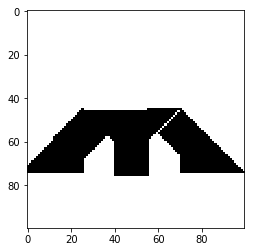

In [13]:
plt.imshow(img1)

In [14]:
def RandomShuffleOneShape(shapeIdx, shapeInfoList, pointDic, width = 100, height = 100, scale = 1, degree = np.pi/12):
    newShapeInfo = None
    newShapeListIndex = 0
    for i in range(len(shapeInfoList)):
        if shapeInfoList[i]["shapeId"] == shapeIdx:
            newShapeListIndex = i
            newShapeInfo = shapeInfoList[i]
            break
    
    trial = 0
    del pointDic[shapeIdx]
    while True:
        trial += 1
        #print("trials " + str(trial))
        center_x = np.random.randint(int(random_position_offset * width), int((1 - random_position_offset) * width))
        center_y = np.random.randint(int(random_position_offset * height), int((1 - random_position_offset) * height))
        
        newShapeInfo["shapePositionIds"]["x"] = center_x - width/2
        newShapeInfo["shapePositionIds"]["y"] = -center_y + height/2
        
        
        if(shapeIdx == 1 or shapeIdx == 2): #small triangle
            newShapeInfo["shapeRotationId"] = np.random.randint(0, rotation_types)
            point_t = TriangleVertexPosition(newShapeInfo["shapePositionIds"], newShapeInfo["shapeRotationId"], 10, scale, 2 * np.pi / rotation_types)
        elif(shapeIdx == 5): #middle triangle
            newShapeInfo["shapeRotationId"] = np.random.randint(0, rotation_types)
            point_t = TriangleVertexPosition(newShapeInfo["shapePositionIds"], newShapeInfo["shapeRotationId"], 10 * 1.414, scale, 2 * np.pi / rotation_types)    
        elif(shapeIdx == 6 or shapeIdx == 7): #large triangle
            newShapeInfo["shapeRotationId"] = np.random.randint(0, rotation_types)
            point_t = TriangleVertexPosition(newShapeInfo["shapePositionIds"], newShapeInfo["shapeRotationId"], 10 * 2, scale, 2 * np.pi / rotation_types)
        elif(shapeIdx == 3): # square
            newShapeInfo["shapeRotationId"] = np.random.randint(0, rotation_types // 4)
            point_t = SquareVertexPosition(newShapeInfo["shapePositionIds"], newShapeInfo["shapeRotationId"], 10, scale, 2 * np.pi / rotation_types)
        else: # =4 parallelogram
            newShapeInfo["shapeRotationId"] = np.random.randint(- rotation_types // 2, rotation_types // 2)
            point_t = ParallelogramVertexPosition(newShapeInfo["shapePositionIds"], newShapeInfo["shapeRotationId"], 5, scale, 2 * np.pi / rotation_types)
            
        polygon_new = Polygon(point_t)
#         print("new", polygon_new)
#         img2, pt2 = DrawImageFromShapeInfo(shapeInfoList, 1)
#         plt.imshow(img2)
#         plt.show()
        
        #print(point_t)
        isOverlap = False
        for key in pointDic:
            polygon = Polygon(pointDic[key])
            #print(polygon)
            
            if(polygon.intersects(polygon_new)):
                isOverlap = True
                break
            if isOverlap:
                break
        
        #print("has overlap?", isOverlap)
        if (not isOverlap) or (trial > 100):
            pointDic[shapeIdx] = point_t
            break

In [17]:
def ShuffleTangram(shapeInfoList, moveSequence, filePath, scale = 1):
    #make folder
    try:
        os.mkdir(filePath)
    except OSError:
        print ("Creation of the directory %s failed" % filePath)
    else:
        print ("Successfully created the directory %s " % filePath)
        
    print("shuffle and save images...")
    #calculate place sequence as the reverse order  of place sequence
    placeSequence = []
    for element in moveSequence[::-1]:
        if element in placeSequence:
            continue
        placeSequence.append(element)

    for shapeId in shapeIdList:
        if not shapeId in placeSequence:
            placeSequence.append(shapeId)
            
    # save the original image
    img, pointList = DrawImageFromShapeInfo(shapeInfoList, scale)
    cv2.imwrite(os.path.join(filePath , '0.jpg'), img)
    plt.imshow(img)
    plt.show()
    
    # shuffle and save images
    for i, idx in enumerate(placeSequence):
        RandomShuffleOneShape(idx, shapeInfoList, pointList, boardWidth/gridStep, boardHeight/gridStep, scale)
        img, pointList = DrawImageFromShapeInfo(shapeInfoList, scale)
        cv2.imwrite(os.path.join(filePath , str(i+1) + '.jpg'), img)
        plt.imshow(img)
        plt.show()
    
    print("finished!")
    

In [15]:
os.getcwd()

'E:\\researches\\Tangram\\python'

In [16]:
filePath = "tmp"

Creation of the directory tmp failed
shuffle and save images...


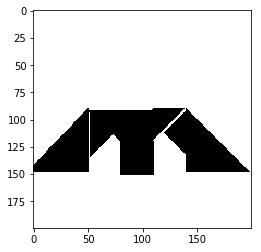

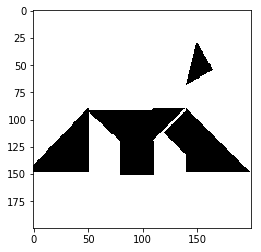

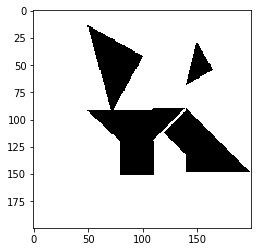

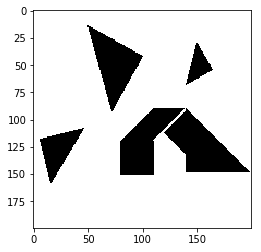

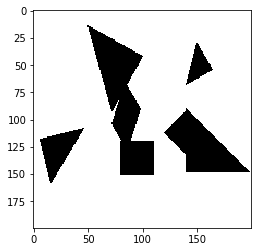

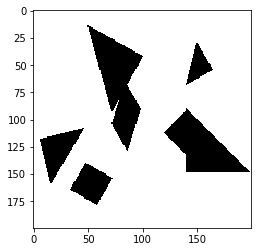

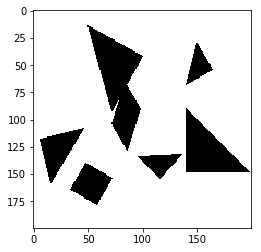

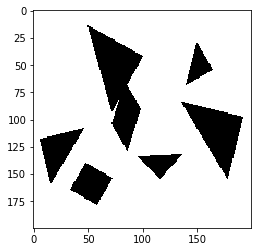

finished!


In [18]:
ShuffleTangram(sevenShapeInfo, moveSequence, filePath, scale = image_scale)